In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../../../fastai/")

from fastai.imports import *
from fastai.transforms  import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [12]:
PATH = ''
sz = 224
f_model = resnet34
bs = 128

In [13]:
ls {PATH}

__MACOSX/                                         train-jpg/
planet-understanding-the-amazon-from-space.ipynb  train-jpg.tar
test-jpg/                                         train-jpg.tar.7z
test-jpg.tar                                      train_v2.csv
test-jpg.tar.7z                                   train_v2.csv.zip
tmp/


In [14]:
label_csv=f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [15]:
n

40479

In [16]:
label_df=pd.read_csv(label_csv)
label_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [33]:
def get_data(sz):
    tfms = tfms_from_model(f_model,sz,aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms, 
                  suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')
#batch size not set here

In [34]:
data = get_data(256)

In [19]:
fn = PATH+data.trn_ds.fnames[0]; fn

'train-jpg/train_0.jpg'

In [20]:
x,y = next(iter(data.val_dl))

In [21]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [22]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

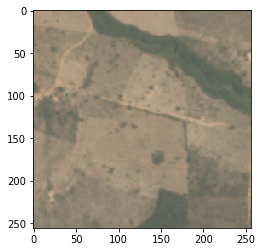

In [23]:
plt.imshow(data.val_ds.denorm(to_np(x))[2]) #??

In [24]:
sz = 64

In [25]:
data = get_data(sz)

In [26]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [27]:
learn = ConvLearner.pretrained(f_model, data)

In [18]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.224377   0.310743   0.914166  



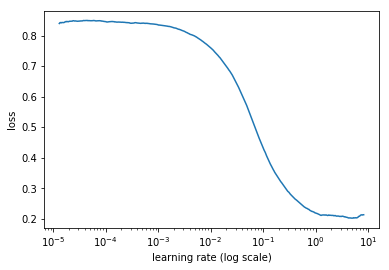

In [19]:
learn.sched.plot()

In [20]:
lr = 0.2

In [75]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.139152   0.127496   0.94941   
    1      0.136617   0.125872   0.95018                     
    2      0.134203   0.124628   0.950594                    
    3      0.137813   0.125226   0.950064                    
    4      0.132105   0.122887   0.951401                    
    5      0.128226   0.122166   0.951386                    
    6      0.130269   0.121873   0.951728                    



[array([ 0.12187]), 0.95172764341944605]

In [76]:
lrs = np.array([lr/9,lr/3,lr])

In [78]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.120486   0.110625   0.956313  
    1      0.117872   0.105238   0.958122                    
    2      0.108271   0.101328   0.960419                    
    3      0.110102   0.102852   0.959343                    
    4      0.1073     0.101432   0.96023                     
    5      0.099541   0.097803   0.96185                      
    6      0.099548   0.098073   0.961545                     



[array([ 0.09807]), 0.96154489030508139]

In [79]:
learn.save(f'{sz}')

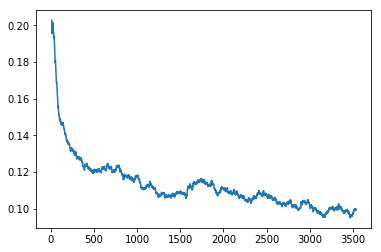

In [80]:
learn.sched.plot_loss()

In [81]:
sz = 128

In [82]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.097939   0.097297   0.961697  
    1      0.096049   0.096385   0.962017                     
    2      0.09928    0.094914   0.962657                     
    3      0.097967   0.094981   0.962635                     
    4      0.094513   0.092911   0.963718                     
    5      0.094668   0.093096   0.963689                     
    6      0.094269   0.093008   0.963558                     



[array([ 0.09301]), 0.96355775077818651]

In [90]:
learn.save(f'{sz}')

In [91]:
learn.unfreeze()
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.092672   0.088525   0.965469  
    1      0.094267   0.087628   0.965941                     
    2      0.089218   0.08606    0.966719                     
    3      0.092154   0.087549   0.965956                     
    4      0.089878   0.086429   0.966007                     
    5      0.085191   0.084922   0.967053                     
    6      0.084662   0.085061   0.967206                     



In [92]:
sz=256
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.091884   0.089948   0.965026  
    1      0.085819   0.088633   0.965331                     
    2      0.090716   0.088801   0.965294                     
    3      0.090805   0.0884     0.965469                     
    4      0.089806   0.087959   0.965658                     
    5      0.089891   0.08775    0.965701                     
    6      0.087958   0.08744    0.965825                     



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.086447   0.083337   0.967431  
    1      0.089298   0.083372   0.967525                     
    2      0.082286   0.082087   0.96807                      
    3      0.084681   0.084316   0.96682                      
    4      0.08375    0.082335   0.967932                     
    5      0.08058    0.081742   0.968092                     
    6      0.08003    0.08148    0.968383                     



In [28]:
learn.load(f'256')

In [29]:
log_preds, y = learn.TTA(is_test = True)
probs = np.mean(np.exp(log_preds),0)

In [30]:
probs.shape

(40669, 17)

In [31]:
df=pd.DataFrame(probs)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.921674,1.001157,1.013771,1.000902,1.000261,2.637427,1.000021,1.000220,1.267462,2.686334,1.010363,1.002757,2.707335,1.390704,1.000339,1.003473,1.599331
1,1.020679,1.000065,1.002458,1.071095,1.001479,2.700511,1.000045,1.000413,1.028295,1.017609,1.002768,1.001732,2.717532,1.005179,1.017221,1.001291,1.017783
2,1.722181,1.000007,1.001341,1.000016,1.000003,2.694528,1.000002,1.000009,1.013944,1.000515,1.004206,1.000206,2.717944,1.050113,1.000006,1.000074,2.557044
3,1.101078,1.011389,1.025414,1.000096,1.000001,2.718192,1.000000,1.000459,1.006265,1.199517,1.000316,1.000000,2.715693,1.167978,1.000023,1.000193,2.718272
4,1.000399,1.000016,1.000006,1.000038,1.000026,1.000325,1.733075,1.000027,1.000054,1.000055,1.429699,1.197157,1.575043,1.000058,1.000011,1.000008,1.000554


In [36]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [39]:
df.columns = data.classes
df.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,1.921674,1.001157,1.013771,1.000902,1.000261,2.637427,1.000021,1.000220,1.267462,2.686334,1.010363,1.002757,2.707335,1.390704,1.000339,1.003473,1.599331
1,1.020679,1.000065,1.002458,1.071095,1.001479,2.700511,1.000045,1.000413,1.028295,1.017609,1.002768,1.001732,2.717532,1.005179,1.017221,1.001291,1.017783
2,1.722181,1.000007,1.001341,1.000016,1.000003,2.694528,1.000002,1.000009,1.013944,1.000515,1.004206,1.000206,2.717944,1.050113,1.000006,1.000074,2.557044
3,1.101078,1.011389,1.025414,1.000096,1.000001,2.718192,1.000000,1.000459,1.006265,1.199517,1.000316,1.000000,2.715693,1.167978,1.000023,1.000193,2.718272
4,1.000399,1.000016,1.000006,1.000038,1.000026,1.000325,1.733075,1.000027,1.000054,1.000055,1.429699,1.197157,1.575043,1.000058,1.000011,1.000008,1.000554
